## RQ 2: What is the performance distribution given the respective achievement level of the pair programmers?

Investigation of debugging scores differences basing from achievement level groups 
- Determine each student’s achievement level by mean score -- when pre-test score is below the mean, the student will be tagged as a Low performer, and the otherwise High performer
- Assign pairs to three achievement level groups: High-High, High-Low, and Low-Low performers
- Assign the pair’s debugging score differences to the achievement level groups
- Investigate properties through distribution analysis

TODO
- Include volume in features /
- Investigate multicollinearity



In [1]:
import pandas as pd
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cols_classes = ['ArgCcl', 'ArgCnt', 'ArgCon', 'ArgEla', 'ArgRsn', 'EliOpn', 'EliPrp', 'EliSet', 'EliVer',
                'ImpAct', 'ImpFoc', 'InfAct', 'InfNeg', 'InfNeu', 'InfNon', 'InfPos', 'InfSoc', 'InfSol',
                'InfStm', 'ResCfm', 'ResDen','ResSol', 'ResStm']
class_group = ['Arg', 'Eli', 'Imp', 'Inf', 'Res']
cols_classes_groups = ['grp_' + grp for grp in class_group]
cols_tests = ['pre_test_score', 'self_efficacy', 'debugging_scores']

In [3]:
stud_df = pd.read_csv("data/proc/student_data.csv", index_col="student")

In [4]:
stud_df["static_or_dynamic"].value_counts()

Static     59
Dynamic    50
Name: static_or_dynamic, dtype: int64

In [5]:
# Assigning mean scores and performance level by static/dynamic
df_stud_static = stud_df[stud_df["static_or_dynamic"] == "Static"]
df_stud_dynamic = stud_df[stud_df["static_or_dynamic"] == "Dynamic"]

ds_static_cutoff = df_stud_static["debugging_scores"].mean()
ds_dynamic_cutoff = df_stud_dynamic["debugging_scores"].mean()

df_stud_static["debugging_perf"] = df_stud_static["debugging_scores"].apply(lambda x: "L" if x < ds_static_cutoff else "H")
df_stud_dynamic["debugging_perf"] = df_stud_dynamic["debugging_scores"].apply(lambda x: "L" if x < ds_dynamic_cutoff else "H")

/home/jerelyn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jerelyn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [6]:
# Collate back to single df
stud_df = df_stud_static.append(df_stud_dynamic)

In [7]:
# Student pairing - code from MG. Modified to include performance level
temp_remove_pair = {'ADDU-DP02', 'ADDU-SP04'} 
unique_pairs = set(stud_df.index.str[:-1]) - temp_remove_pair
pair_df = pd.DataFrame(index=unique_pairs, columns=cols_classes + cols_tests + ['school', 'static_or_dynamic', 'gender', 'debugging_perf_pair'])

for pair in unique_pairs:
    try:
        pair_df.loc[pair][cols_tests] = stud_df.loc[pair + 'A'].get(cols_tests).subtract(stud_df.loc[pair + 'B'].get(cols_tests)).abs()
        stud_a_perf = stud_df.loc[pair+'A'].get("debugging_perf")
        stud_b_perf = stud_df.loc[pair+'B'].get("debugging_perf")
        if stud_a_perf == stud_b_perf:
            if stud_a_perf == "H":
                pair_df.loc[pair]["debugging_perf_pair"] = "HH"
            else:
                pair_df.loc[pair]["debugging_perf_pair"] = "LL"
        else:
            pair_df.loc[pair]["debugging_perf_pair"] = "HL"
        pair_df.loc[pair][['school', 'static_or_dynamic', 'gender']] = stud_df.loc[pair + 'A'][['school', 'static_or_dynamic', 'gender']]
    except KeyError as e:
        print("Invalid pair due to outliers: {}".format(pair))
        
pair_df[cols_tests] = pair_df[cols_tests].apply(pd.to_numeric, errors='coerce', axis=1)

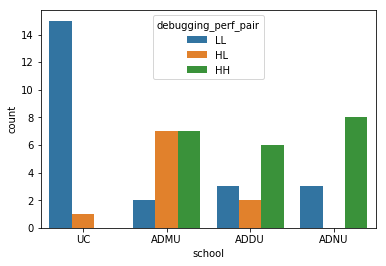

In [22]:
sns.countplot(x="school", hue="debugging_perf_pair", data=pair_df,palette=["C0", "C1", "C2"])

No assigned pairs with debugging performance level of HL for ADNU and HH for UC. This could be because of drops in observations due to erroneous rows assignments and removal of outliers in classes. Furthermore, looks like there's a lot of LL pairs in UC. Let's see it in the next diagram:

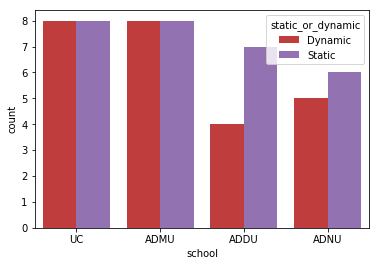

In [28]:
sns.countplot(x="school", hue="static_or_dynamic", data=pair_df, palette=["C3", "C4"])

8, 6, 7 removed from ADDU, ADMU, and ADNU, respectively. More observations removed from Static scenario.

5 removed from ADNU, and ADDU

Text(0,0.5,'debugging score difference')

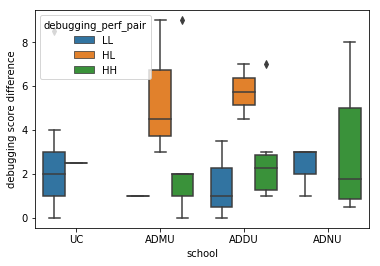

In [20]:
ax = sns.boxplot(x="school", y="debugging_scores", hue="debugging_perf_pair", data=pair_df, palette=["C0", "C1", "C2"])
ax.set_ylabel("debugging score difference")

Looks like there's a relatively large variance for the HL group in ADMU and HH group in ADNU.

### BUT, I don't think we'll be showing by University data.

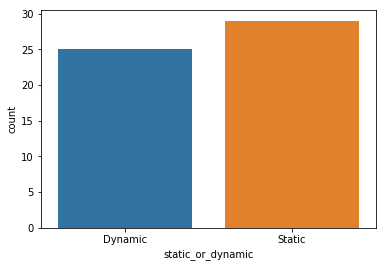

In [11]:
sns.countplot(x="static_or_dynamic", data=pair_df)

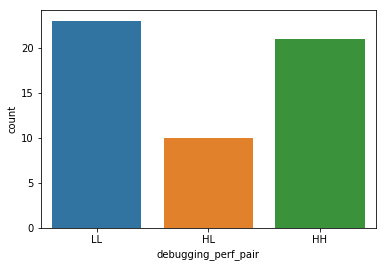

In [12]:
sns.countplot(x="debugging_perf_pair", data=pair_df)

Text(0,0.5,'debugging score difference')

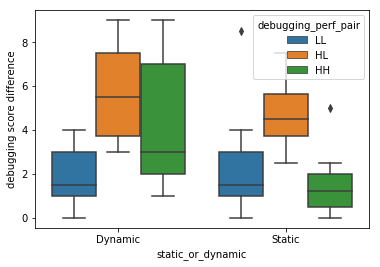

In [29]:
ax = sns.boxplot(x="static_or_dynamic", y="debugging_scores", hue="debugging_perf_pair", data=pair_df, palette=["C0", "C1", "C2"])
ax.set_ylabel("debugging score difference")

Higher differences in HL groups, followed by LL and HH groups for Static. Meanwhile, consistently high difference for HL group, followed by HH then LL for Dynamic.

In [14]:
stud_df_melt = stud_df.melt()

In [15]:
stud_df_melted = pd.merge(pd.melt(stud_df.reset_index(), id_vars=("student"), value_vars=cols_classes, var_name="class"), 
                          stud_df.reset_index()[["student", "debugging_perf"]], on="student")
stud_df_melted.head()

,student,class,value,debugging_perf
0,ADDU-SP01A,ArgCcl,0.0,L
1,ADDU-SP01A,ArgCnt,0.0,L
2,ADDU-SP01A,ArgCon,0.0,L
3,ADDU-SP01A,ArgEla,0.0,L
4,ADDU-SP01A,ArgRsn,0.0,L


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

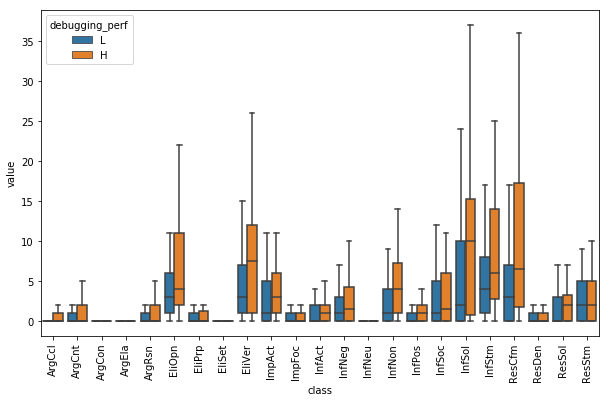

In [16]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="class", y="value", hue="debugging_perf",data=stud_df_melted, showfliers=False)
plt.xticks(rotation=90)

In [17]:
from scipy.stats import normaltest
from scipy.stats import boxcox, boxcox_normplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

ArgCcl


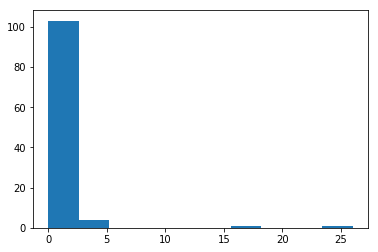

Statistics=185.949, p=0.000
Sample does not look Gaussian (reject H0)
ArgCnt


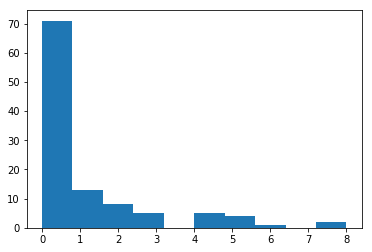

Statistics=58.118, p=0.000
Sample does not look Gaussian (reject H0)
ArgCon


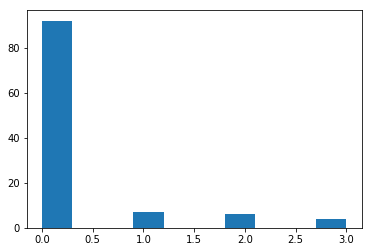

Statistics=74.638, p=0.000
Sample does not look Gaussian (reject H0)
ArgEla


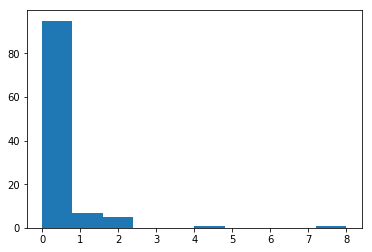

Statistics=164.369, p=0.000
Sample does not look Gaussian (reject H0)
ArgRsn


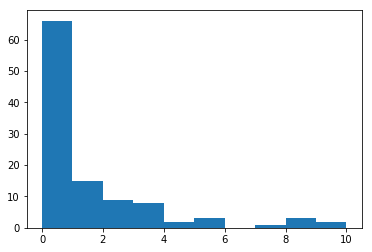

Statistics=68.700, p=0.000
Sample does not look Gaussian (reject H0)
EliOpn


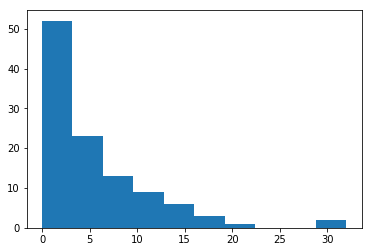

Statistics=59.254, p=0.000
Sample does not look Gaussian (reject H0)
EliPrp


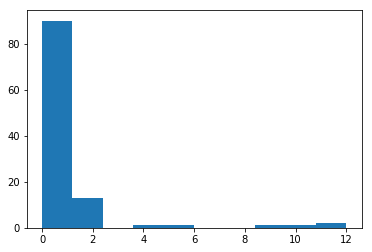

Statistics=115.900, p=0.000
Sample does not look Gaussian (reject H0)
EliSet


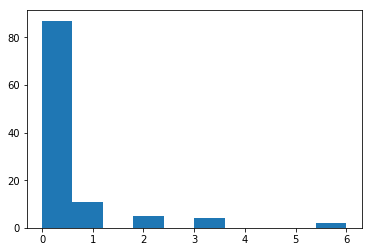

Statistics=106.083, p=0.000
Sample does not look Gaussian (reject H0)
EliVer


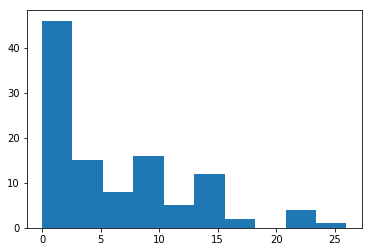

Statistics=18.286, p=0.000
Sample does not look Gaussian (reject H0)
ImpAct


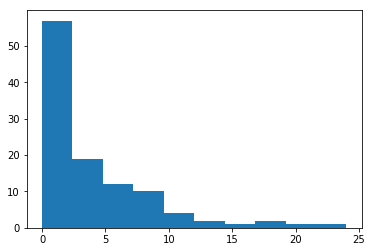

Statistics=50.095, p=0.000
Sample does not look Gaussian (reject H0)
ImpFoc


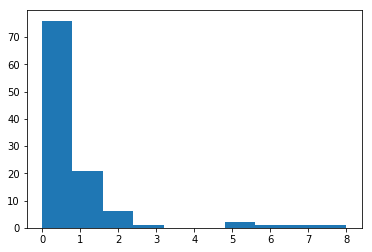

Statistics=103.852, p=0.000
Sample does not look Gaussian (reject H0)
InfAct


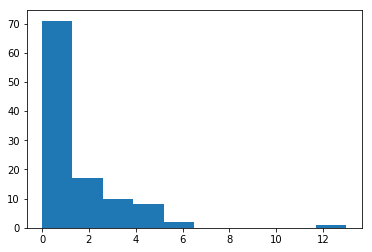

Statistics=93.010, p=0.000
Sample does not look Gaussian (reject H0)
InfNeg


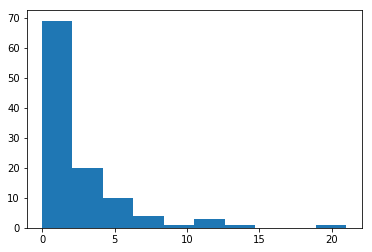

Statistics=77.162, p=0.000
Sample does not look Gaussian (reject H0)
InfNeu


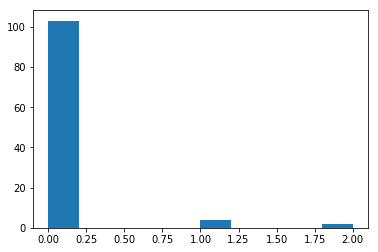

Statistics=138.844, p=0.000
Sample does not look Gaussian (reject H0)
InfNon


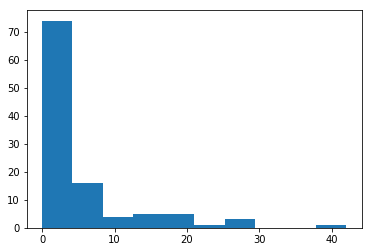

Statistics=73.170, p=0.000
Sample does not look Gaussian (reject H0)
InfPos


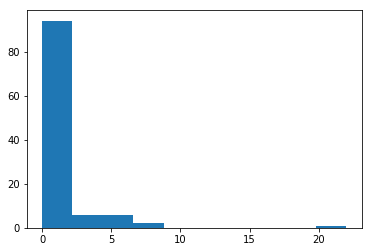

Statistics=146.969, p=0.000
Sample does not look Gaussian (reject H0)
InfSoc


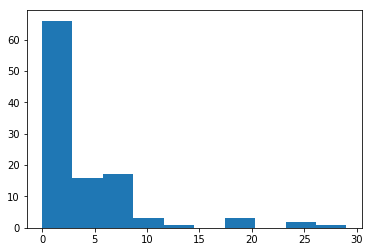

Statistics=73.758, p=0.000
Sample does not look Gaussian (reject H0)
InfSol


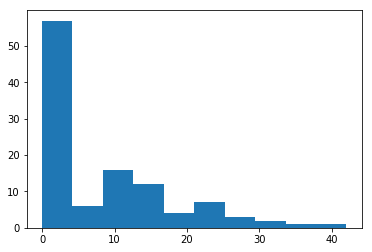

Statistics=22.981, p=0.000
Sample does not look Gaussian (reject H0)
InfStm


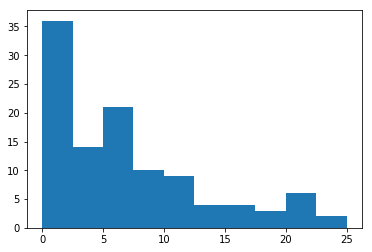

Statistics=18.974, p=0.000
Sample does not look Gaussian (reject H0)
ResCfm


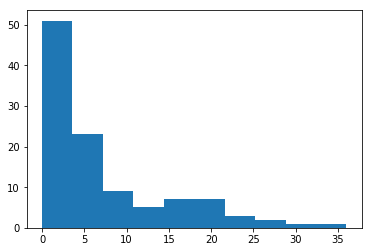

Statistics=30.486, p=0.000
Sample does not look Gaussian (reject H0)
ResDen


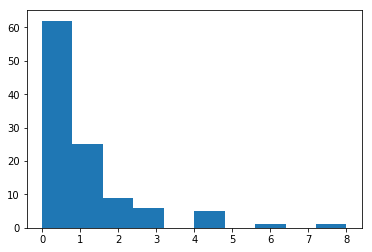

Statistics=69.856, p=0.000
Sample does not look Gaussian (reject H0)
ResSol


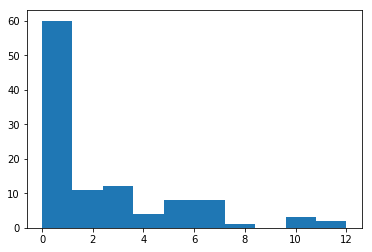

Statistics=31.935, p=0.000
Sample does not look Gaussian (reject H0)
ResStm


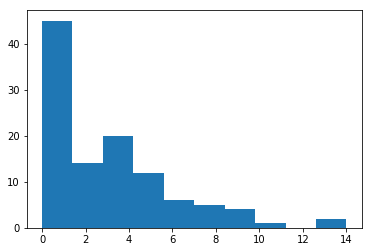

Statistics=27.907, p=0.000
Sample does not look Gaussian (reject H0)


In [18]:
for col in cols_classes:
    print(col)
    data = stud_df[col]
    stat, p = normaltest(data)
    plt.hist(data)
    plt.show()
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')